# ElasticNet

## Imports / Settings

In [1]:
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import os
import wandb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from utils.evaluationUtility import evaluate_classifier, analyze_all_results

In [4]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [5]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb._disable_jupyter = True

wandb: Currently logged in as: dario-wigger (nlp-lantsch-schmassmann-wigger). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data

In [6]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

## Vectorization

In [7]:
countVectorizer = CountVectorizer()
tfidfVectorizer = TfidfVectorizer()

## Training

In [8]:
classifier = SGDClassifier(
    penalty='elasticnet',
    loss='log_loss',
    l1_ratio=0.5,
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5
)

In [9]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="SGD-Elasticnet",
    vectorizer=countVectorizer,
    vectorizer_name="CountVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="elasticNet"
)

Inference time for 44999 texts: 0.8297 seconds

Classifier: SGD-Elasticnet | Vectorizer: CountVectorizer
Validation Accuracy: 0.7695
Test Accuracy: 0.7690
Training Duration: 3.61 seconds


f1,▁
precision,▁
recall,▁
f1,0.76601
precision,0.76825
recall,0.76895


In [10]:
evaluate_classifier(
    classifier=classifier,
    classifier_name="SGD-Elasticnet",
    vectorizer=tfidfVectorizer,
    vectorizer_name="TfIdfVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="elasticNet"
)

Inference time for 44999 texts: 0.6042 seconds

Classifier: SGD-Elasticnet | Vectorizer: TfIdfVectorizer
Validation Accuracy: 0.7519
Test Accuracy: 0.7523
Training Duration: 3.55 seconds


f1,▁
precision,▁
recall,▁
f1,0.74716
precision,0.75276
recall,0.75231


## Hyperparameter Tuning

In [20]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SGDClassifier(penalty='elasticnet', loss='log_loss', early_stopping=True, n_iter_no_change=5))
])

param_grid = {
    'classifier__alpha': [1e-4, 1e-3, 1e-2],
    'classifier__l1_ratio': [0.35, 0.5, 0.85],
    'classifier__max_iter': [500, 1000, 1500],
    'vectorizer__max_features': [1000, 5000, 10000],
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid.fit(train_texts, train_labels)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.15, classifier__max_iter=1000, vectorizer__max_features=1000; total time=   5.8s
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.15, classifier__max_iter=2000, vectorizer__max_features=1000; total time=   5.0s
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.5, classifier__max_iter=1000, vectorizer__max_features=1000; total time=   5.2s
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.5, classifier__max_iter=2000, vectorizer__max_features=1000; total time=   4.3s
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.5, classifier__max_iter=2000, vectorizer__max_features=10000; total time=   5.1s
[CV] END classifier__alpha=0.0001, classifier__l1_ratio=0.85, classifier__max_iter=1000, vectorizer__max_features=10000; total time=   5.9s
[CV] END classifier__alpha=0.001, classifier__l1_ratio=0.15, classifier__max_iter=1000, vectorizer__max_f

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(early_stopping=True,
                                                      loss='log_loss',
                                                      penalty='elasticnet'))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01],
                         'classifier__l1_ratio': [0.35, 0.5, 0.85],
                         'classifier__max_iter': [500, 1000, 1500],
                         'vectorizer__max_features': [1000, 5000, 10000]},
             scoring='f1_macro', verbose=2)

In [21]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'classifier__alpha': 0.0001, 'classifier__l1_ratio': 0.35, 'classifier__max_iter': 500, 'vectorizer__max_features': 5000}


In [11]:
evaluate_classifier(
    classifier=SGDClassifier(loss='log_loss', early_stopping=True, alpha=1e-4, max_iter=500, random_state=42, l1_ratio=0.35),
    classifier_name="SGD-Elasticnet-Tuned",
    vectorizer=TfidfVectorizer(max_features=5000),
    vectorizer_name="TfIdfVectorizer",
    train_texts=train_texts,
    train_labels=train_labels,
    validation_texts=validation_texts,
    validation_labels=validation_labels,
    test_texts=test_texts,
    test_labels=test_labels,
    model_name="elasticNet"
)

Inference time for 44999 texts: 0.6350 seconds

Classifier: SGD-Elasticnet-Tuned | Vectorizer: TfIdfVectorizer
Validation Accuracy: 0.7679
Test Accuracy: 0.7690
Training Duration: 2.71 seconds


f1,▁
precision,▁
recall,▁
f1,0.76592
precision,0.76845
recall,0.76902


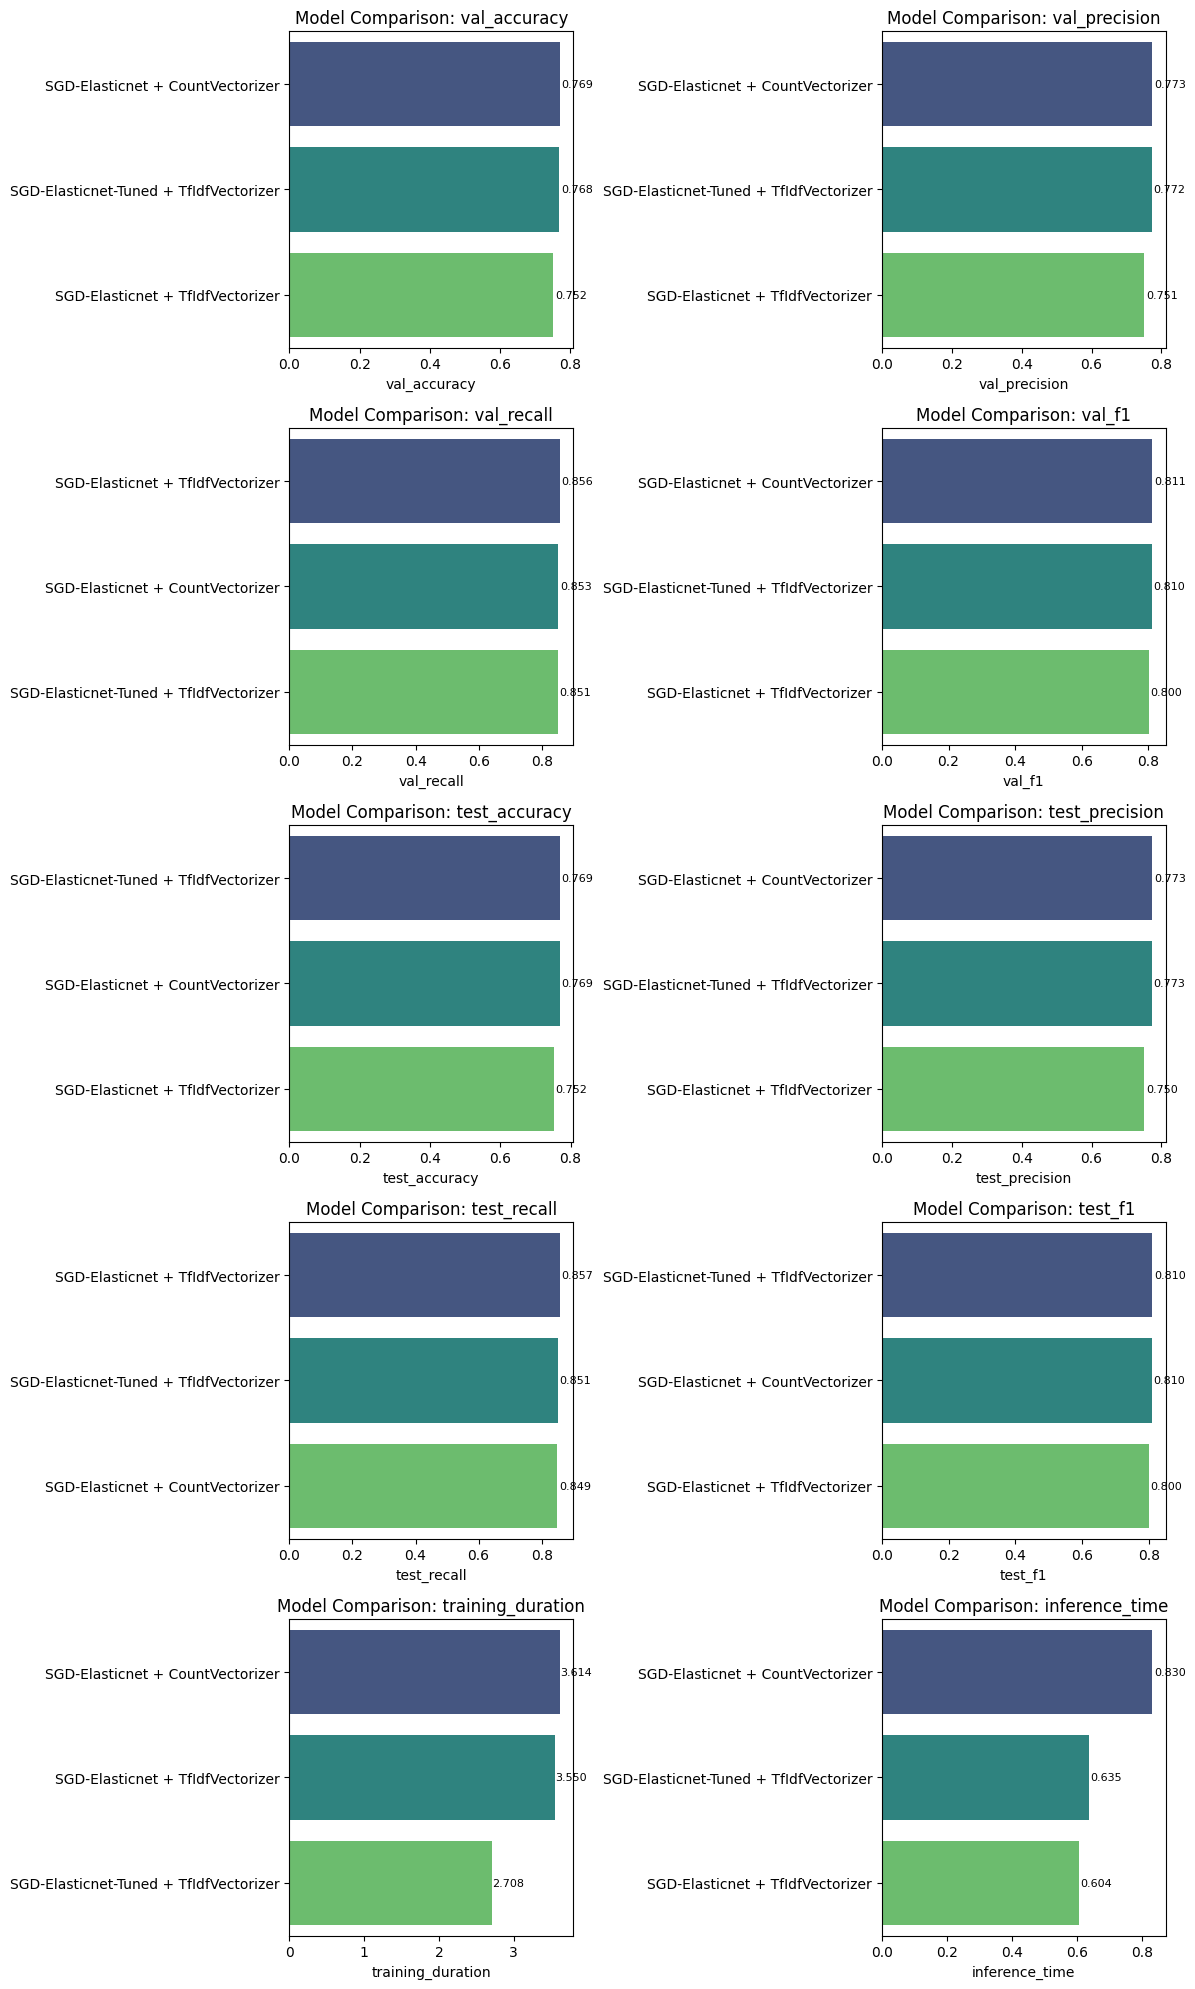

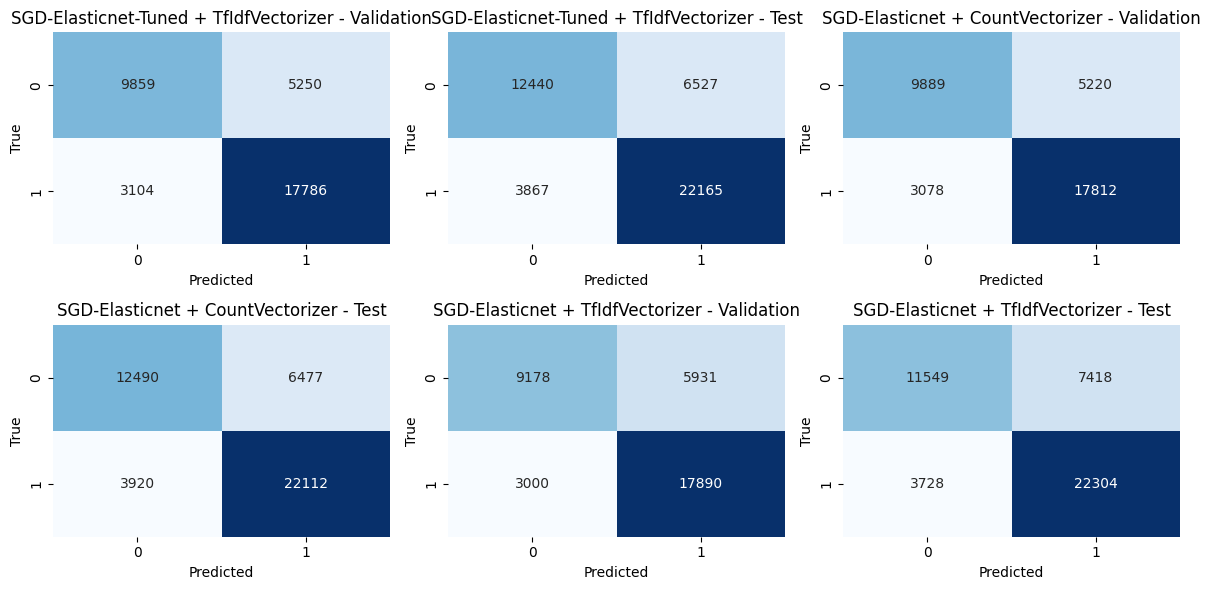

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,training_duration,inference_time,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,SGD-Elasticnet-Tuned,TfIdfVectorizer,0.767938,0.772096,0.851412,0.809817,0.769017,0.772515,0.851452,0.810065,2.707754,0.634988,SGD-Elasticnet-Tuned,TfIdfVectorizer,"[[9859, 5250], [3104, 17786]]","[[12440, 6527], [3867, 22165]]",SGD-Elasticnet-Tuned + TfIdfVectorizer
1,SGD-Elasticnet,CountVectorizer,0.769494,0.773359,0.852657,0.811074,0.768950,0.773444,0.849416,0.809652,3.613779,0.829683,SGD-Elasticnet,CountVectorizer,"[[9889, 5220], [3078, 17812]]","[[12490, 6477], [3920, 22112]]",SGD-Elasticnet + CountVectorizer
2,SGD-Elasticnet,TfIdfVectorizer,0.751910,0.751018,0.856391,0.800250,0.752306,0.750421,0.856792,0.800086,3.550043,0.604193,SGD-Elasticnet,TfIdfVectorizer,"[[9178, 5931], [3000, 17890]]","[[11549, 7418], [3728, 22304]]",SGD-Elasticnet + TfIdfVectorizer


In [12]:
analyze_all_results(results_dir="executions/elasticNet")